# Red neuronal atractora

Según Wikipedia una ANN evoluciona hasta llegar a un patrón estable. Voy a utilizar esta característica para la reconstrucción de imágenes.  

Ésta fue la primera red neuronal que construí y la hice desde cero, sin bibliotecas demasiado específicas como Keras, así que voy a explicar todo el proceso.

Primero importo las bibliotecas necesarias.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

Voy a crear una función para generar la red. El grafo será representado mediante una lista de listas que contenga los vecinos de cada nodo. Además, se necesita de otra matriz para los pesos de las conexiones entre los nodos. 

In [2]:
def create_network(num_nodes = 100, p_conection=0.5):
    network = []
    weights_matrix = []
    for _ in range(num_nodes):
        neighbors = bernoulli.rvs(p_conection, size=num_nodes)    
        neighbors = np.where(neighbors==1)[0]
        #conexiones de la neurona
        network.append(neighbors)
        #pesos de las conexiones
        weights_matrix.append(np.zeros(len(neighbors)))
                
    return network,weights_matrix

Ahora tengo que modificar los pesos para que la red neuronal pueda aprender el patrón que quiero enseñarle. Así que utilizaré el aprendizaje Hebbiano. Si las neuronas se activan juntas, la conexión se refuerza.

In [3]:
#aprender un patron dado una red y el patrón
def learn(network,weights_matrix,pattern):
    #voy a recorrer los vecinos de cada nodo
    for i,neighbors in enumerate(network):
        #hebbian learning
        weights_matrix[i] += pattern[neighbors] * pattern[i]

Ya que tengo la red y los pesos, necesito una función para que la red evolucione hacia el patrón que le enseñé. Esto se realiza tomando el valor de cada vecino de la neurona para multiplicarlo por su peso correspondiente. Al final se suman estos resultados.

In [4]:
#las neuronas utilizarán los pesos para reconstruir la imagen
def evolve(network, weights_matrix, current_state):
    new_state = np.zeros(len(current_state))
    #voy a recorrer los vecinos de cada nodo
    for i,neighbors in enumerate(network):
        #índicees de los vecinos
        #cambio de estado
        new_state[i] = sum(current_state[neighbors]*weights_matrix[i])
        if(new_state[i]<0):
            new_state[i] = -1
        else:
            new_state[i] = 1
    return new_state


## Datos de entrada

Como dije, utilizaré una imagen para esta red, eso significa que debo realizar cierto preprocesamiento de los datos.

In [111]:
img = cv2.imread("network_img.png",0)

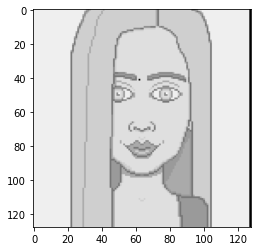

In [61]:
plt.imshow(img,'gray')

In [62]:
img.shape

(128, 128)

Voy a cambiar el shape para que no tome demasiado procesamiento.

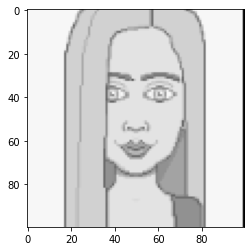

In [112]:
img = cv2.resize(img,(100,100))
plt.imshow(img,'gray')

Voy a trabajar con la imagen de la forma más simple posible, así que voy a tomar un límite para binarizar la imagen.

In [113]:
threshold = img.mean()
threshold

211.9934

In [114]:
img[np.where(img<threshold)]= 0
img[np.where(img>=threshold)]= 1

Tengo que convertir el tipo de dato para que no me dé problemas más adelante.

In [115]:
img = np.array(img, dtype='int8')
img[np.where(img==0)]=-1 

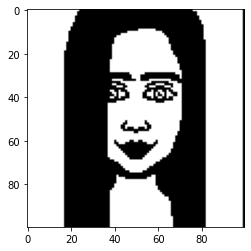

In [116]:
plt.imshow(img,'gray')

In [117]:
img.mean()

0.1176

Finalmente, tengo que aplanar la imagen.

In [118]:
flat_img = np.resize(img,img.size)

Este vector ya puede ser aprendido por la red neuronal.

## Aprender el patrón

Creo una nueva red neuronal y su matriz de pesos.

In [119]:
network,weights_matrix = create_network(num_nodes=len(flat_img),p_conection=0.3)

In [120]:
len(network)

10000

Le enseño el patrón, o sea la imagen plana.

In [121]:
learn(network,weights_matrix,flat_img)

## Probar el aprendizaje

Ahora voy a introducir ruido en la imagen y veremos si la red puede reconstruirla.

In [122]:
random_img = flat_img.copy()

In [123]:
noise = bernoulli.rvs(0.5, size=len(random_img))    

In [124]:
random_img[np.where(noise==1)]=-1

Veamos la imagen con ruido devolviendo las dimensiones al vector plano.

In [125]:
noise_img = np.resize(random_img,img.shape)


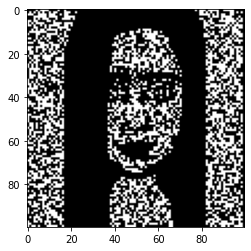

In [126]:
plt.imshow(noise_img, 'gray')

Ahora debo ingresar este vector ruidoso a la red y dejar que evolucione.

In [127]:
new_state = evolve(network,weights_matrix,random_img)

Veamos cómo se ve después de la primera ronda.

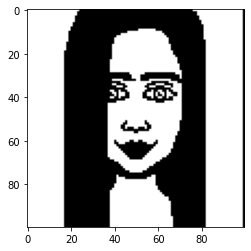

In [128]:
new_img = np.resize(new_state,img.shape)
plt.imshow(new_img,'gray')

Al parecer la reconstrucción fue bastante buena, voy a definir una función para comparar el resultado de la reconstrucción con el original. Consiste en multiplicar los valores de cada vector. Gracias a la binarización, los vectores sólo tienen 1 y -1, así que al multiplicar los valores, si son iguales, sumarán y si son diferentes, restarán.  
Al final divido la suma para el total de nodos y tengo el porcentaje de acierto.

In [25]:
def compare(original,result):
    return sum(original*result)/len(original)

In [129]:
compare(flat_img,new_state)

1.0

La reconstrucción fue perfecta. Así que voy a traer nuevos patrones para seguir probando la capacidad de la red.

## Más patrones

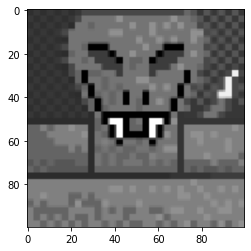

In [130]:
logo = cv2.imread("logo.png",0)
logo = cv2.resize(logo,(100,100))
plt.imshow(logo,'gray')

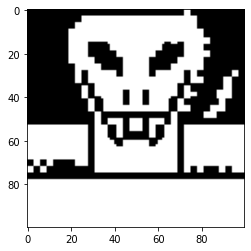

In [131]:
#límite para binarizar
threshold = logo.mean()
#binarización
logo[np.where(logo<threshold)]= 0
logo[np.where(logo>=threshold)]= 1
#cambio del tipo de dato para admitir -1
logo = np.array(logo, dtype='int8')
logo[np.where(logo==0)]=-1 
#imprimo
plt.imshow(logo,'gray')

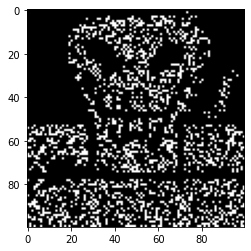

In [132]:
#aplano la imagen
flat_logo = np.resize(logo,logo.size)
#aprendo el patrón
learn(network,weights_matrix,flat_logo)
#creo una imagen con ruido
random_logo = flat_logo.copy()
noise = bernoulli.rvs(0.7, size=len(random_logo))    
random_logo[np.where(noise==1)]=-1
noise_logo = np.resize(random_logo,logo.shape)
plt.imshow(noise_logo,'gray')

In [133]:
#Ingreso la imagen con ruido
new_state = evolve(network,weights_matrix,random_logo)

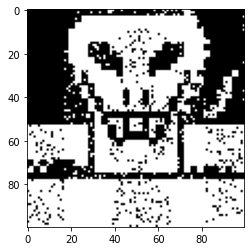

In [134]:
new_logo = np.resize(new_state,logo.shape)
plt.imshow(new_logo,'gray')

In [135]:
compare(flat_logo,new_state)

0.8824

En este caso la reconstrucción no fue perfecta, pero tal vez necesite una evolución más.

In [136]:
#Ingreso la imagen con ruido
new_state2 = evolve(network,weights_matrix,new_state)

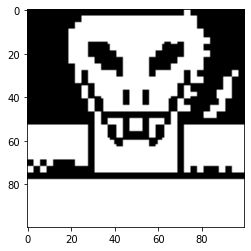

In [137]:
new_logo = np.resize(new_state2,logo.shape)
plt.imshow(new_logo,'gray')

Parece que la imagen finalmente está reconstruida, puedo realizar la comparación.

In [138]:
compare(flat_logo,new_state2)

1.0

Y efectivamente la reconstrucción fue exitosa en un 100%.

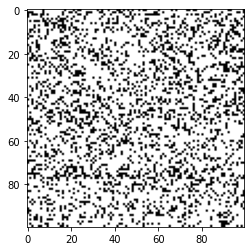

In [139]:
#creo una imagen con ruido
random_logo = flat_logo.copy()
noise = bernoulli.rvs(0.7, size=len(random_logo))    
random_logo[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.7, size=len(random_logo))    
random_logo[np.where(noise==1)]=1

noise_logo = np.resize(random_logo,logo.shape)
plt.imshow(noise_logo,'gray')

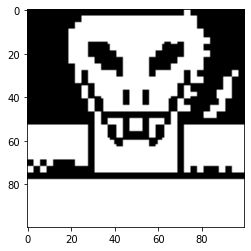

In [140]:
random_logo = evolve(network,weights_matrix,random_logo)
new_logo = np.resize(random_logo,logo.shape)
plt.imshow(new_logo,'gray')

In [141]:
compare(flat_logo,random_logo)

1.0

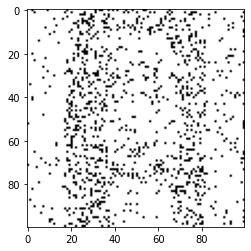

In [142]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.2, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

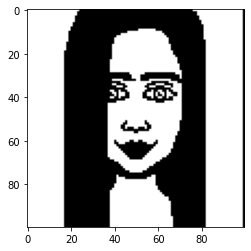

In [143]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

In [144]:
compare(flat_img,random_img)

1.0

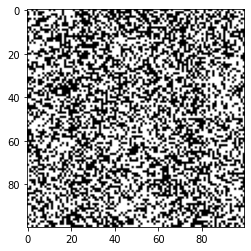

In [158]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.5, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

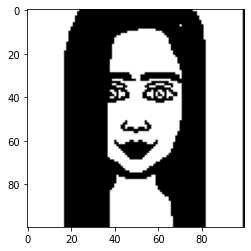

In [159]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

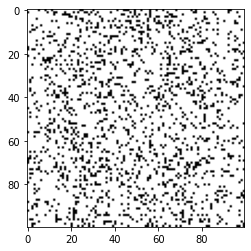

In [155]:
#creo una imagen con ruido
random_img = flat_img.copy()
noise = bernoulli.rvs(0.7, size=len(random_img))    
random_img[np.where(noise==1)]=-1
noise = bernoulli.rvs(0.8, size=len(random_img))    
random_img[np.where(noise==1)]=1

noise_img = np.resize(random_img,img.shape)
plt.imshow(noise_img,'gray')

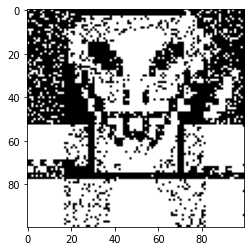

In [156]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')

Aquí la red cometió un error y reconstruyó el otro patrón. Esto puede deberse a que la cantidad de conexiones es muy pobre. En los ejemplos anteriores se muestra que se puede agregar bastante ruido a ambas imágenes y las reconstruirá, pero existe un límite de reconocimiento.

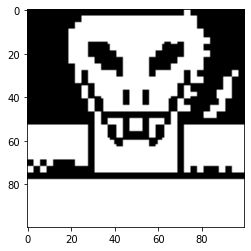

In [157]:
random_img = evolve(network,weights_matrix,random_img)
new_img = np.resize(random_img,img.shape)
plt.imshow(new_img,'gray')